# Traffic Prediction using ARIMA and Prophet

# Importing Libraries

In [31]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#import tensorflow
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
#from tensorflow import keras
#from keras import callbacks
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
#from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [32]:
#Loading Data
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. 
The CSV file provides four features:

* DateTime
* Junctions
* Vehicles
* ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

# Data Exploration

In [33]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [34]:
data

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


Text(0.5, 0, 'Date')

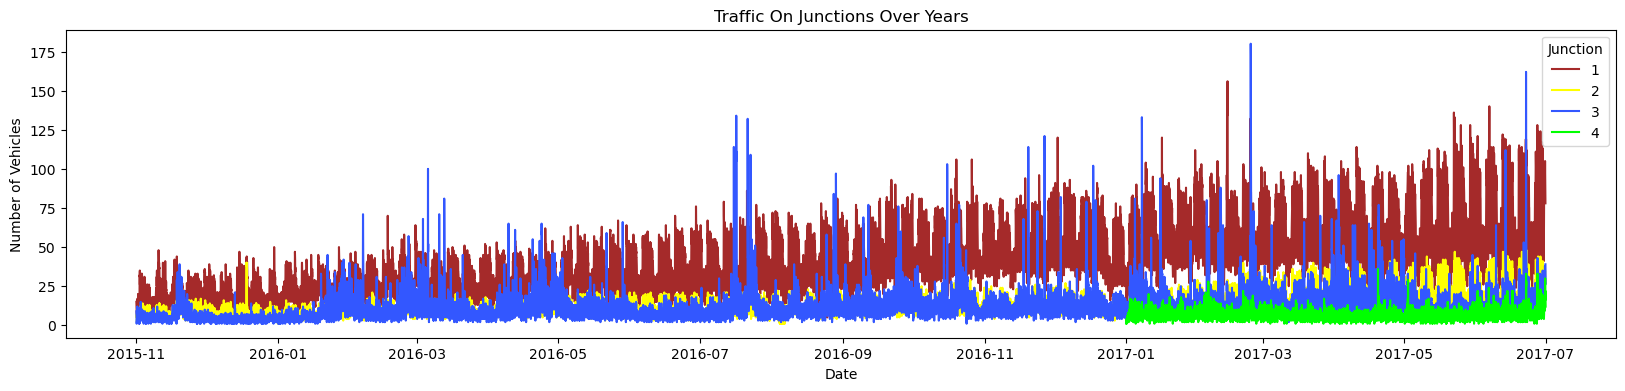

In [35]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = ["#A52A2A", "#FFFF00", "#3357FF", "#00FF00"]
plt.figure(figsize=(20,4))#,facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Noticeable information in the above plot:**

* It can be seen here that the first junction is visibly having an upward trend.
* The data for the fourth junction is sparse starting only after 2017
* Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it. 

# Feature Engineering

At this step, I am creating a few new features out of DateTime. 
Namely:
* Year
* Month 
* Date in the given month
* Days of week 
* Hour

In [36]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


# Exploratory Data Analysis

Plotting the newly created features

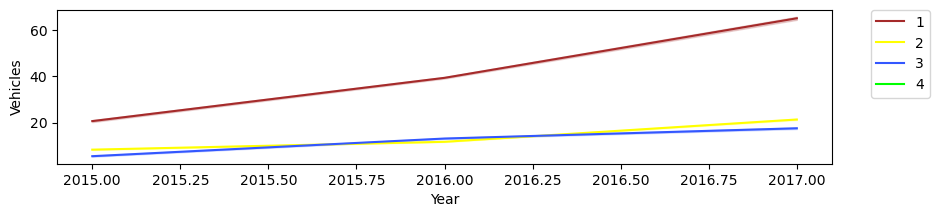

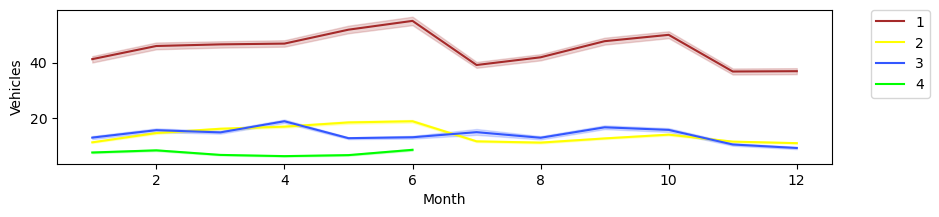

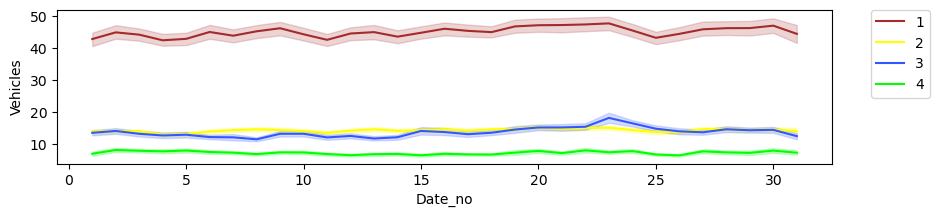

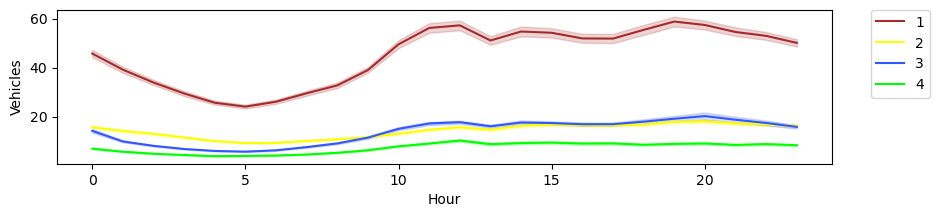

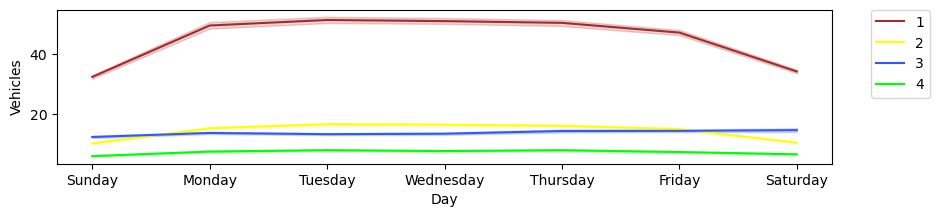

In [37]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2))#,facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**From the above plot following things can be concluded:**


* Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.  

* We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same. 

* Monthly, throughout all the dates there is a good consistency in data. 

* For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation. 

* For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady. 


Text(0.5, 0, 'Date')

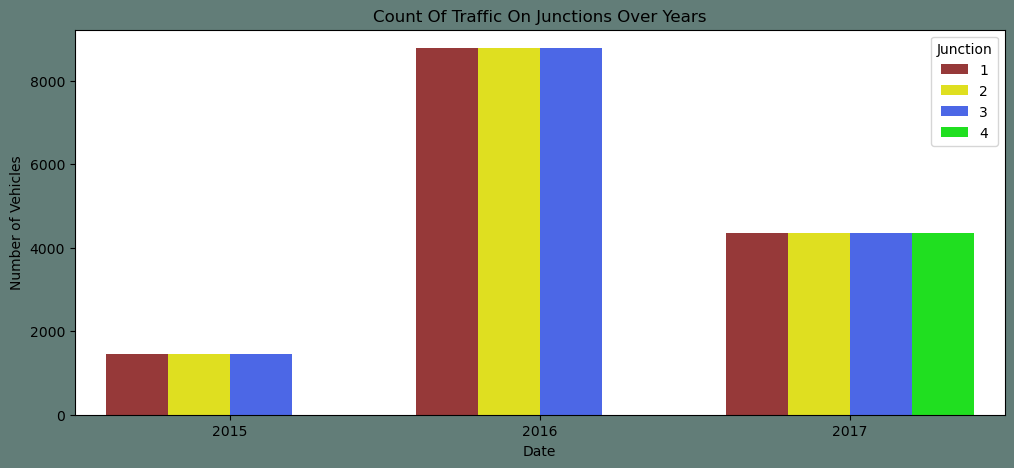

In [38]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month. 

<Axes: >

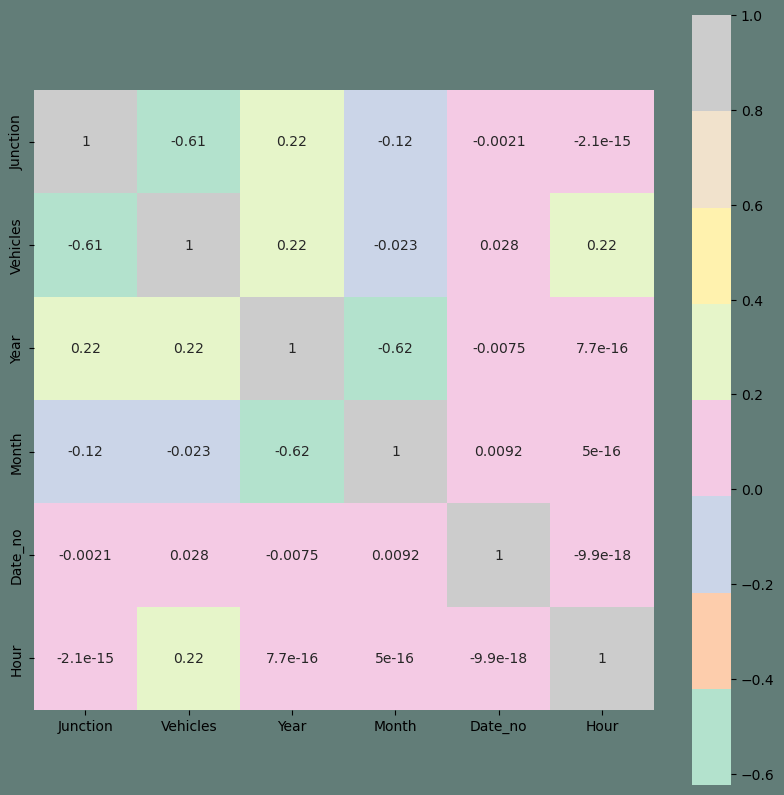

In [39]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

The highest correlation is certainly with the preexisting feature. 

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data. 

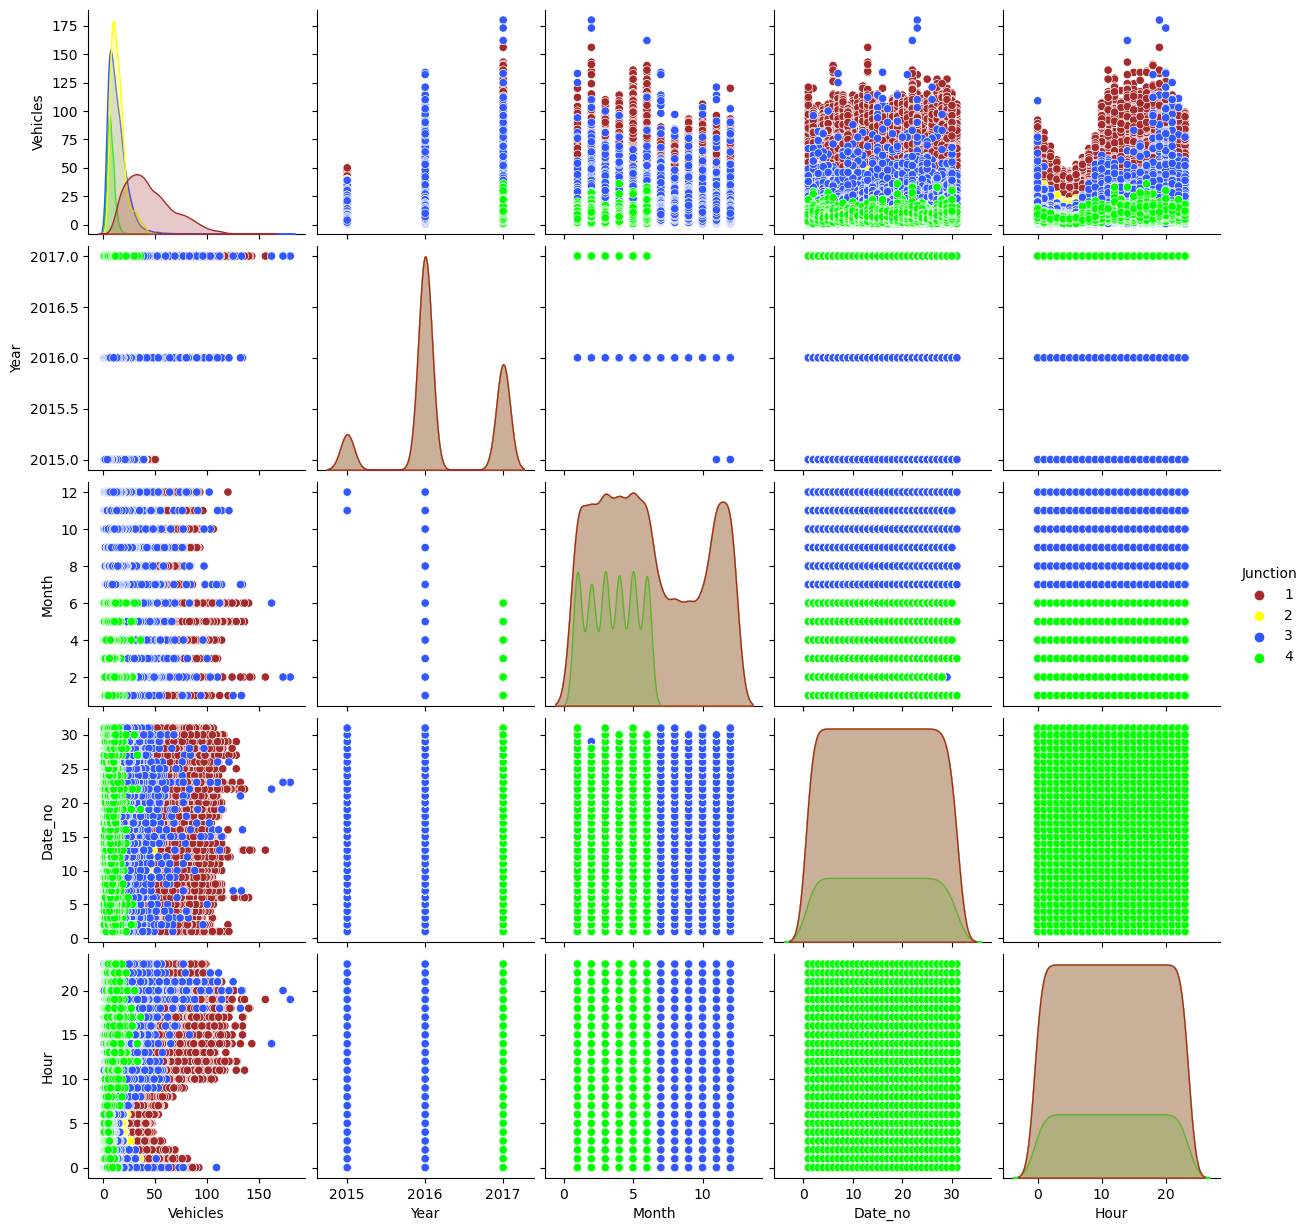

In [40]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Conclusions that I have come to draw after this EDA**

* The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
* The yearly trend for Junctions one, two and three have diffrent slopes. 
* Junction number one has a more strong weekly seasonality in comparison to the other junctions. 

For the above-postulated reasons, I think that junctions must be transformed as per their individual needs. 



# Data Transformation And Preprocessing

**In this step I will be following the subsequent order:**

* Creating different frames for each Junction and plotting them
* Transforming the series and plotting them
* Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
* Creating test and train sets


In [41]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

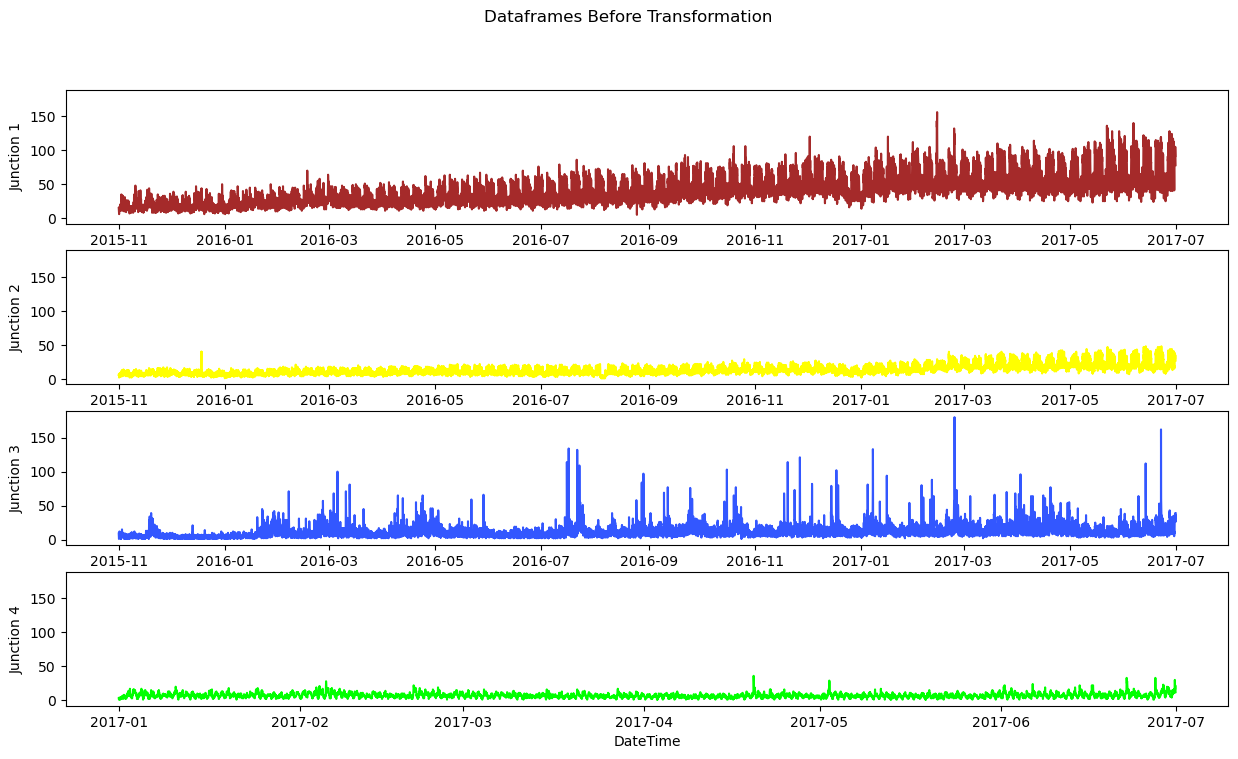

In [42]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)#,facecolor="white", 
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [43]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Junction one, I will be taking a difference of weekly values. 
* For junction two, The difference of consecutive days is a better choice
* For Junctions three and four, the difference of the hourly values will serve the purpose. 

In [44]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

**Plots of Transformed Dataframe**

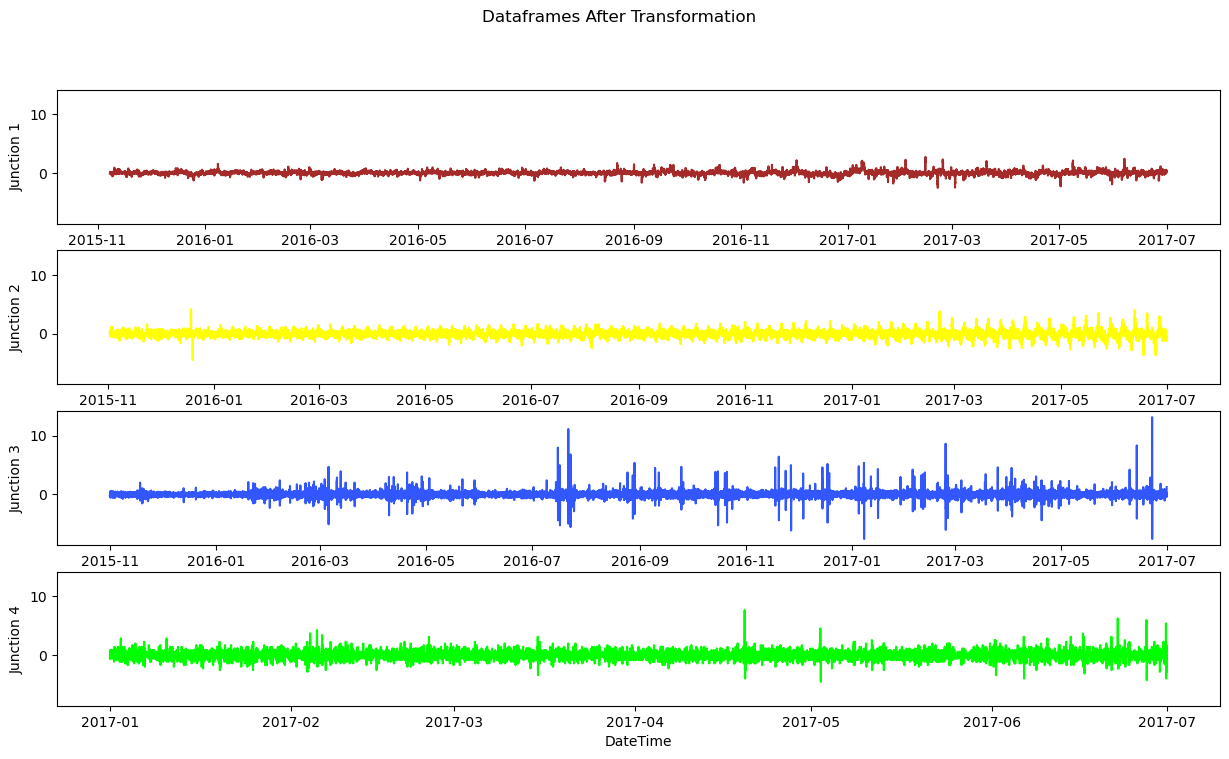

In [45]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test. 

In [46]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415426
p-value: 4.7985398763968885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940296
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832412
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305261
p-value: 2.778787532594783e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [47]:
#df to be used for EDA
df_J1=df.copy()

In [48]:
#Exploring more features 
df_J1["Year"]= df_J1['DateTime'].dt.year
df_J1["Month"]= df_J1['DateTime'].dt.month
df_J1["Date_no"]= df_J1['DateTime'].dt.day
df_J1["Hour"]= df_J1['DateTime'].dt.hour
df_J1["Day"]= df_J1.DateTime.dt.strftime("%A")

In [49]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Model Building

In [50]:
# ARIMA Model
def train_arima_model(train, order):
    model = ARIMA(train, order=order)
    arima_model = model.fit()
    return arima_model

# Prophet Model
def train_prophet_model(train):
    train = train.reset_index()
    train = train.rename(columns={'DateTime': 'ds', 'Diff': 'y'})
    model = Prophet(yearly_seasonality=True)
    prophet_model = model.fit(train)
    return prophet_model

# Function to make predictions
def make_arima_predictions(model, test_size):
    arima_predictions = model.get_forecast(steps=test_size)
    arima_forecast = arima_predictions.predicted_mean
    return arima_forecast

def make_prophet_predictions(model, test_size):
    future = model.make_future_dataframe(periods=test_size, freq='H')
    prophet_predictions = model.predict(future)
    prophet_forecast = prophet_predictions.tail(test_size)['yhat']
    return prophet_forecast

# Train and make predictions for Junction 1 using ARIMA
arima_model_J1 = train_arima_model(df_J1['Diff'], order=(5, 1, 0))
arima_forecast_J1 = make_arima_predictions(arima_model_J1, len(J1_test))

# Train and make predictions for Junction 1 using Prophet
prophet_model_J1 = train_prophet_model(df_J1)
prophet_forecast_J1 = make_prophet_predictions(prophet_model_J1, len(J1_test))

# Train and make predictions for Junction 2 using ARIMA
arima_model_J2 = train_arima_model(df_J2['Diff'], order=(5, 1, 0))
arima_forecast_J2 = make_arima_predictions(arima_model_J2, len(J2_test))

# Train and make predictions for Junction 2 using Prophet
prophet_model_J2 = train_prophet_model(df_J2)
prophet_forecast_J2 = make_prophet_predictions(prophet_model_J2, len(J2_test))

# Train and make predictions for Junction 3 using ARIMA
arima_model_J3 = train_arima_model(df_J3['Diff'], order=(5, 1, 0))
arima_forecast_J3 = make_arima_predictions(arima_model_J3, len(J3_test))

# Train and make predictions for Junction 3 using Prophet
prophet_model_J3 = train_prophet_model(df_J3)
prophet_forecast_J3 = make_prophet_predictions(prophet_model_J3, len(J3_test))

# Train and make predictions for Junction 4 using ARIMA
arima_model_J4 = train_arima_model(df_J4['Diff'], order=(5, 1, 0))
arima_forecast_J4 = make_arima_predictions(arima_model_J4, len(J4_test))

# Train and make predictions for Junction 4 using Prophet
prophet_model_J4 = train_prophet_model(df_J4)
prophet_forecast_J4 = make_prophet_predictions(prophet_model_J4, len(J4_test))

15:51:10 - cmdstanpy - INFO - Chain [1] start processing
15:51:14 - cmdstanpy - INFO - Chain [1] done processing
15:51:34 - cmdstanpy - INFO - Chain [1] start processing
15:51:37 - cmdstanpy - INFO - Chain [1] done processing
15:51:52 - cmdstanpy - INFO - Chain [1] start processing
15:51:57 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing


# Metrics Evaluation

In [51]:
# Function to calculate metrics
def calculate_metrics1(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mse)  # Calculate RMSE
    #mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100  # Calculate MAPE
    return mse, mae, rmse#, mape

# Calculate metrics for ARIMA and Prophet for each junction
arima_mse_J1, arima_mae_J1, arima_rmse_J1 = calculate_metrics1(J1_test, arima_forecast_J1)
prophet_mse_J1, prophet_mae_J1, prophet_rmse_J1 = calculate_metrics1(J1_test, prophet_forecast_J1)

arima_mse_J2, arima_mae_J2, arima_rmse_J2 = calculate_metrics1(J2_test, arima_forecast_J2)
prophet_mse_J2, prophet_mae_J2, prophet_rmse_J2 = calculate_metrics1(J2_test, prophet_forecast_J2)

arima_mse_J3, arima_mae_J3, arima_rmse_J3 = calculate_metrics1(J3_test, arima_forecast_J3)
prophet_mse_J3, prophet_mae_J3, prophet_rmse_J3 = calculate_metrics1(J3_test, prophet_forecast_J3)

arima_mse_J4, arima_mae_J4, arima_rmse_J4 = calculate_metrics1(J4_test, arima_forecast_J4)
prophet_mse_J4, prophet_mae_J4, prophet_rmse_J4 = calculate_metrics1(J4_test, prophet_forecast_J4)

# Display metrics
print("ARIMA Metrics:")
print(f"Junction 1 - MSE: {arima_mse_J1}, MAE: {arima_mae_J1}, RMSE: {arima_rmse_J1}")
print(f"Junction 2 - MSE: {arima_mse_J2}, MAE: {arima_mae_J2}, RMSE: {arima_rmse_J2}")
print(f"Junction 3 - MSE: {arima_mse_J3}, MAE: {arima_mae_J3}, RMSE: {arima_rmse_J3}")
print(f"Junction 4 - MSE: {arima_mse_J4}, MAE: {arima_mae_J4}, RMSE: {arima_rmse_J4}")

print("\nProphet Metrics:")
print(f"Junction 1 - MSE: {prophet_mse_J1}, MAE: {prophet_mae_J1}, RMSE: {prophet_rmse_J1}")
print(f"Junction 2 - MSE: {prophet_mse_J2}, MAE: {prophet_mae_J2}, RMSE: {prophet_rmse_J2}")
print(f"Junction 3 - MSE: {prophet_mse_J3}, MAE: {prophet_mae_J3}, RMSE: {prophet_rmse_J3}")
print(f"Junction 4 - MSE: {prophet_mse_J4}, MAE: {prophet_mae_J4}, RMSE: {prophet_rmse_J4}")

ARIMA Metrics:
Junction 1 - MSE: 0.15137911360001816, MAE: 0.2980472643008358, RMSE: 0.38907468897374725
Junction 2 - MSE: 1.5889004622013359, MAE: 0.98751412778447, RMSE: 1.2605159507921095
Junction 3 - MSE: 0.43397652338764964, MAE: 0.3703964113615326, RMSE: 0.6587689453728444
Junction 4 - MSE: 1.311926009217071, MAE: 0.8159591925334142, RMSE: 1.145393386228972

Prophet Metrics:
Junction 1 - MSE: 0.11358313396256442, MAE: 0.2346120171605701, RMSE: 0.3370209696184563
Junction 2 - MSE: 1.354030357270622, MAE: 0.8668337256783203, RMSE: 1.1636281009285665
Junction 3 - MSE: 0.4119082310726009, MAE: 0.3459206817403064, RMSE: 0.6418007721034628
Junction 4 - MSE: 1.6053764882317674, MAE: 0.9235837585941221, RMSE: 1.267034525272207


# Forecast Plot

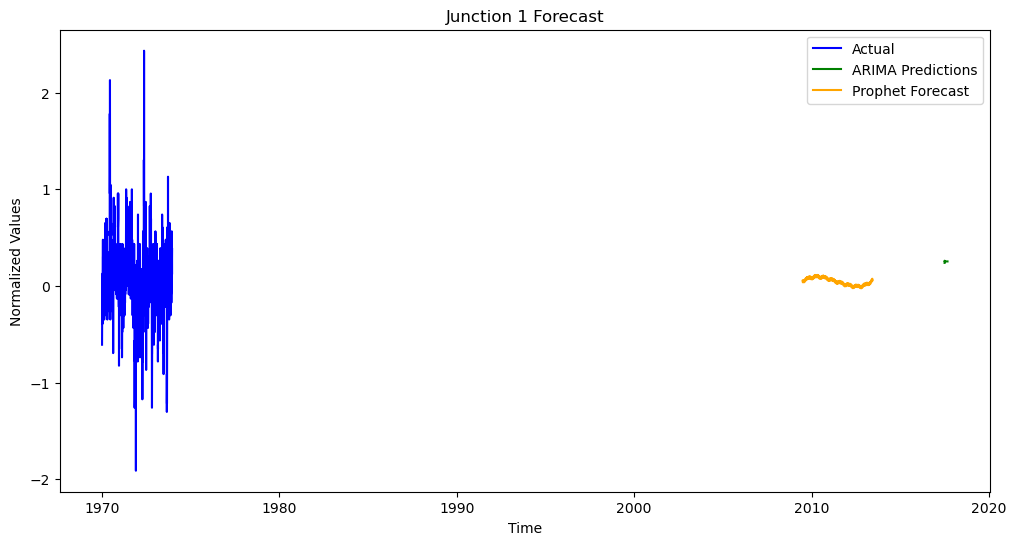

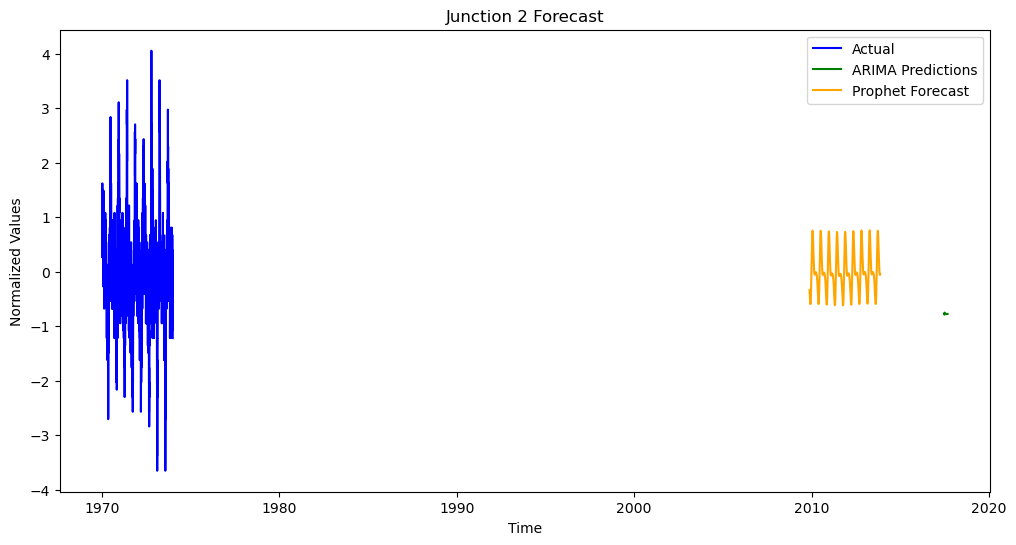

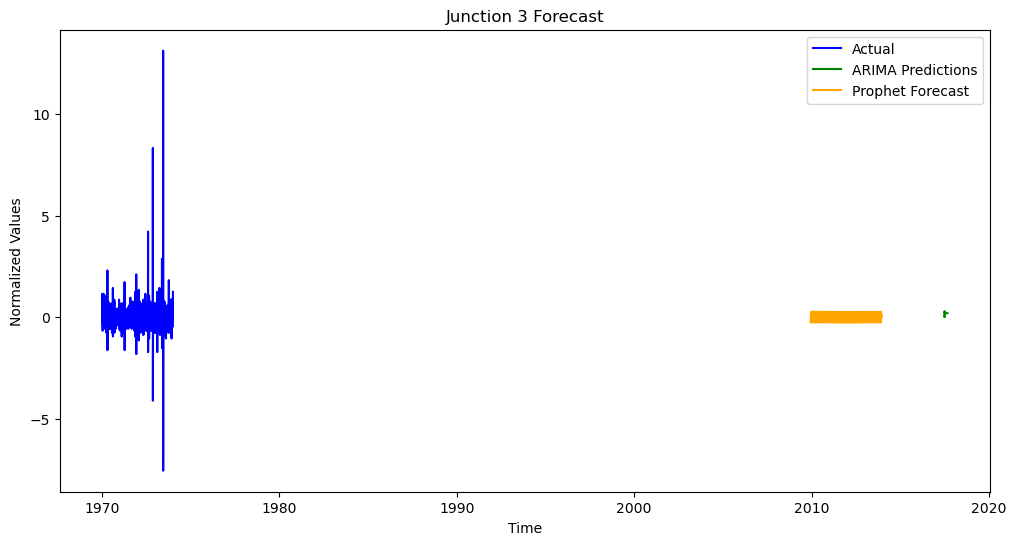

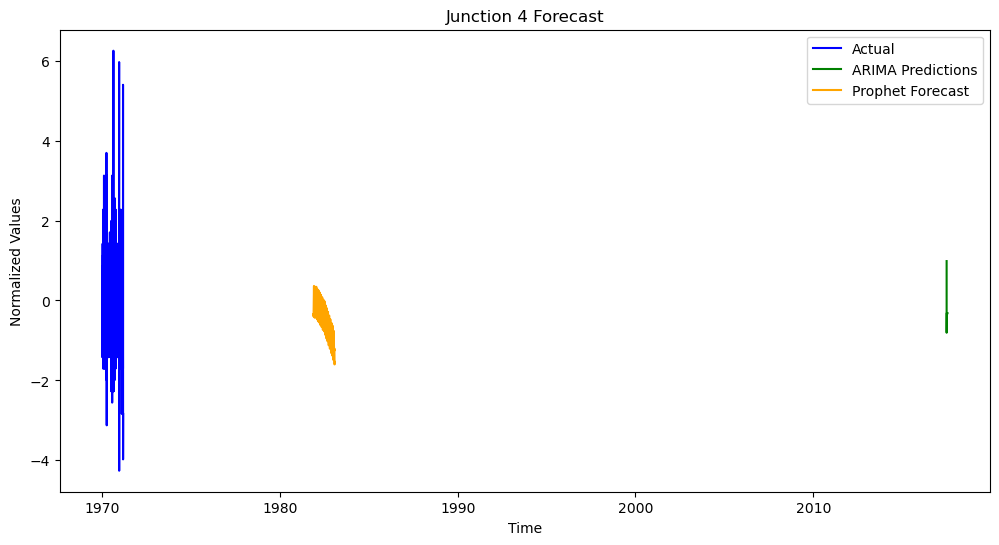

In [52]:
# Function to plot forecasts
def plot_forecasts(actual, predictions, forecast, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predictions, label='ARIMA Predictions', color='green')
    plt.plot(forecast, label='Prophet Forecast', color='orange')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()

# Plot forecasts for Junction 1
plot_forecasts(J1_test, arima_forecast_J1, prophet_forecast_J1, 'Junction 1 Forecast')

# Plot forecasts for Junction 2
plot_forecasts(J2_test, arima_forecast_J2, prophet_forecast_J2, 'Junction 2 Forecast')

# Plot forecasts for Junction 3
plot_forecasts(J3_test, arima_forecast_J3, prophet_forecast_J3, 'Junction 3 Forecast')

# Plot forecasts for Junction 4
plot_forecasts(J4_test, arima_forecast_J4, prophet_forecast_J4, 'Junction 4 Forecast')